# Imports

In [99]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score


import ast

# Path and Load Data 

In [2]:
data = pd.read_csv('politics_[actual_size=4968]_processed_merge.csv').politics
data = pd.DataFrame(data=data)
data.head() 

,politics
0,"['scott', 'pruitt', ""trump'"", 'former', 'epa',..."
1,"['joint', 'fundrais', 'committe', 'run', 'marj..."
2,"['earliest', 'day', 'black', 'church', 'polit'..."
3,"['earli', 'novemb', 'rep', 'chip', 'roy', 'tex..."
4,"['add', 'west', 'wing', 'playbook', 'daili', '..."


In [3]:
politics_positive_tweets = data[:4968] 
print('politics tweets size :', len(politics_positive_tweets))
politics_negative_tweets = data[4968:] 
print('non-politics tweets size :', len(politics_negative_tweets))

politics tweets size : 4968
non-politics tweets size : 5000


* Train test split: 20% will be in the test set, and 80% in the training set.


In [4]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = politics_positive_tweets[4000:]
train_pos = politics_positive_tweets[:4000]

test_neg = politics_negative_tweets[4000:]
train_neg = politics_negative_tweets[:4000]

In [5]:
train_x = pd.concat([train_pos, train_neg], axis=0) 
test_x = pd.concat([test_pos, test_neg], axis=0)

- Create the numpy array of positive labels and negative labels.

In [6]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [7]:
print('train shaoe:', train_y.shape)
print('test shape:', test_y.shape)

train shaoe: (8000, 1)
test shape: (1968, 1)


# Vocabulary for Politics Dataset 

In [8]:
def generate_tweets_list(dataframe_single):
    train_x_arr = [] 
    for index, row in dataframe_single.iterrows(): 
        for a in row.values: 
            train_x_arr.append(ast.literal_eval(a))
            
    return train_x_arr

In [9]:
def build_freqs(train_x, train_y):
    
    yslist = np.squeeze(train_y).tolist()
    train_x_arr = generate_tweets_list(train_x)
    
    freqs = {}
    for y, tweet in zip(yslist, train_x_arr):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [10]:
freqs = build_freqs(train_x, train_y) 
train_x_arr = generate_tweets_list(train_x)

In [11]:
len(freqs)

13201

## Extract Features 
* Given a list of tweets, extract the features and store them in a matrix. Extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train the logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [12]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet 
        freqs: a dictionary corresponding to the frequencies of each tuple 
    Output:
        x: a feature vector of dimension (1, 3)
    '''
    x = np.zeros((1, 3)) 
    x[0,0] = 1 # bias term  
    
    for word in tweet: 
        
        x[0,1] += freqs.get((word, 1.0), 0) 
        
        x[0,2] += freqs.get((word, 0.0), 0) 
        
    assert(x.shape == (1, 3))
    return x 

In [13]:
# Ex 
train_x_arr[0]

['scott',
 'pruitt',
 "trump'",
 'former',
 'epa',
 'chief',
 'run',
 'u',
 'senat',
 'oklahoma',
 'year']

In [14]:
extract_features(train_x_arr[0], freqs)

array([[1.000e+00, 1.169e+03, 2.280e+02]])

In [15]:
extract_features(['asd', 'asd', 'asd'], freqs)

array([[1., 0., 0.]])

In [16]:
X = np.zeros((len(train_x_arr), 3))
for i in range(len(train_x_arr)):
    X[i, :]= extract_features(train_x_arr[i], freqs) 
    
X[:5]

array([[1.000e+00, 1.169e+03, 2.280e+02],
       [1.000e+00, 5.070e+02, 1.930e+02],
       [1.000e+00, 1.379e+03, 7.950e+02],
       [1.000e+00, 1.360e+03, 4.560e+02],
       [1.000e+00, 1.024e+03, 2.760e+02]])

In [17]:
y = train_y

In [18]:
X_sparse = coo_matrix(X)
X, X_sparse, y = shuffle(X, X_sparse, y, random_state=0)

y

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [19]:
X

array([[1.000e+00, 5.390e+02, 4.100e+01],
       [1.000e+00, 6.740e+02, 1.710e+02],
       [1.000e+00, 1.790e+02, 5.320e+02],
       ...,
       [1.000e+00, 3.110e+02, 1.800e+01],
       [1.000e+00, 7.030e+02, 7.500e+01],
       [1.000e+00, 1.143e+03, 1.530e+02]])

In [69]:
vis_X = pd.DataFrame(data=X, columns=['bias', 'positive', 'negative'])
vis_y = pd.DataFrame(data=y, columns=['target']) 

vis_data = pd.concat([vis_X, vis_y], axis=1) 

vis_data.head() 

,bias,positive,negative,target
0,1.0,539.0,41.0,1.0
1,1.0,674.0,171.0,1.0
2,1.0,179.0,532.0,0.0
3,1.0,2524.0,1134.0,1.0
4,1.0,360.0,53.0,1.0


<Figure size 720x720 with 0 Axes>

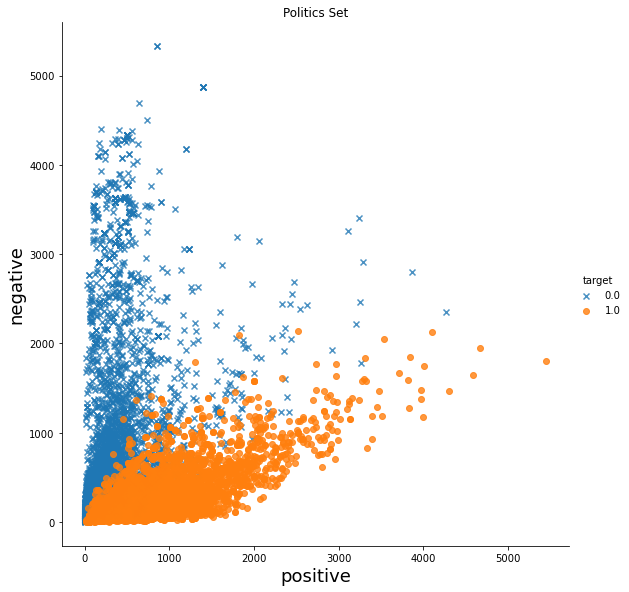

In [98]:
plt.figure(figsize=(10,10))
#plt.scatter(x='positive', y='negative', data=vis_data, c=vis_data.target, alpha=0.8, cmap='viridis', s=15)
sns.lmplot(x='positive', y='negative', data=vis_data, hue='target', fit_reg=False, height=8, markers=['x','o'])
plt.title('Politics Set')
plt.xlabel('positive', fontsize=18)
plt.ylabel('negative', fontsize=18) 
plt.show() 

# Classifier  1 : Logistic Regression 

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


# 1.1 Apply Logistic Regression and Cross - Validation 

* As a reminder, We have a balanced dataset. 

In [20]:
cross_val_score(LogisticRegression(), X, y.ravel())

array([0.9275  , 0.913125, 0.929375, 0.930625, 0.930625])

- We have very satisfying results. Let's do some hyper-parameter tuning.

# 1.2 Grid Search on Logistic Regression

In [48]:
%%time
gs_model = LogisticRegression(solver='liblinear') 
space = {
    'C': [1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

search = GridSearchCV(gs_model, space, scoring='accuracy', cv = 5) 
search.fit(X, y.ravel())  

Wall time: 279 ms


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100]},
             scoring='accuracy')

In [49]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9275
Best Hyperparameters: {'C': 1e-05}


In [50]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003987,0.000003,0.000600,0.000490,0.0,{'C': 1e-10},0.930000,0.915625,0.923750,0.928125,0.930000,0.925500,0.005440,9
1,0.005385,0.000487,0.000599,0.000489,0.00001,{'C': 1e-05},0.930000,0.916875,0.928125,0.930000,0.932500,0.927500,0.005491,1
2,0.004388,0.000489,0.000599,0.000489,0.0001,{'C': 0.0001},0.930625,0.916250,0.928125,0.929375,0.932500,0.927375,0.005747,3
3,0.004335,0.006112,0.000000,0.000000,0.001,{'C': 0.001},0.930000,0.917500,0.927500,0.930000,0.931875,0.927375,0.005130,2
4,0.003426,0.006853,0.000000,0.000000,0.01,{'C': 0.01},0.929375,0.913750,0.926875,0.930625,0.930000,0.926125,0.006317,4
5,0.006027,0.007390,0.000000,0.000000,0.1,{'C': 0.1},0.927500,0.913125,0.926875,0.930625,0.930625,0.925750,0.006500,5
6,0.006248,0.007653,0.000000,0.000000,1,{'C': 1},0.927500,0.913125,0.926875,0.930625,0.930625,0.925750,0.006500,5
7,0.009453,0.005833,0.000000,0.000000,10,{'C': 10},0.927500,0.913125,0.926875,0.930625,0.930625,0.925750,0.006500,5
8,0.003124,0.006248,0.000000,0.000000,100,{'C': 100},0.927500,0.913125,0.926875,0.930625,0.930625,0.925750,0.006500,5


# Test Logistic Regression Model

In [39]:
test_x_arr = generate_tweets_list(test_x)

In [40]:
X_test = np.zeros((len(test_x_arr), 3))
for i in range(len(test_x_arr)):
    X_test[i, :]= extract_features(test_x_arr[i], freqs) 
    
X_test[:5]

array([[1.000e+00, 1.019e+03, 3.750e+02],
       [1.000e+00, 5.290e+02, 1.790e+02],
       [1.000e+00, 6.160e+02, 3.250e+02],
       [1.000e+00, 1.840e+02, 7.800e+01],
       [1.000e+00, 6.470e+02, 2.400e+02]])

In [47]:
search.best_estimator_.score(X_test, test_y.ravel())

0.7205284552845529

In [57]:
y_hat = search.best_estimator_.predict(X_test)
print("F1-Score is", f1_score(test_y.ravel(), y_hat))

F1-Score is 0.7637457044673539


# Classifier 2 : SVM 

In [100]:
clf_svm = SVC(kernel='linear') 
clf_svm.fit(X, y.ravel())

SVC(kernel='linear')

In [101]:
clf_svm.score(X_test, test_y.ravel())

0.7815040650406504

In [102]:
clf_svm.score(X, y.ravel())

0.922875

In [103]:
clf_svm.coef0

0.0

In [104]:
clf_svm.coef_

array([[-1.16529009e-11,  6.97641753e-03, -7.84432370e-03]])

# 2.1 Cross-Validation on Simple SVM Model 

In [105]:
cross_val_score(SVC(kernel='linear'), X, y.ravel(), cv=5)

array([0.925   , 0.911875, 0.924375, 0.929375, 0.924375])

# 2.2 SVM Grid Search on Linear Kernel 

In [108]:
param_grid = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 
    'kernel' : ['linear']
}

grid_svm_linear = GridSearchCV(SVC(), param_grid, refit=3, verbose=3, cv=5)
grid_svm_linear.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ............C=1e-05, kernel=linear;, score=0.925 total time=   0.4s
[CV 2/5] END ............C=1e-05, kernel=linear;, score=0.912 total time=   0.4s
[CV 3/5] END ............C=1e-05, kernel=linear;, score=0.925 total time=   0.4s
[CV 4/5] END ............C=1e-05, kernel=linear;, score=0.929 total time=   0.4s
[CV 5/5] END ............C=1e-05, kernel=linear;, score=0.924 total time=   0.4s
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.926 total time=   0.6s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.912 total time=   0.5s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.924 total time=   0.6s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.929 total time=   0.6s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.924 total time=   0.6s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.926 total time=   1.3s
[CV 2/5] END ............C=0.001, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
                         'kernel': ['linear']},
             refit=3, verbose=3)

In [109]:
grid_svm_linear.best_score_

0.92325

In [110]:
grid_svm_linear.best_estimator_

SVC(C=1e-05, kernel='linear')

In [111]:
grid_svm_linear.best_estimator_.score(X_test, test_y.ravel())

0.7835365853658537

In [112]:
f1_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.8042279411764707

In [117]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.7637457044673539,
        'test accuracy' : 0.7205284552845529
    },
    
    'Linear SVM': {
        'f1 score': 0.8042279411764707, 
        'test accuracy': 0.7835365853658537
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM
f1 score,0.763746,0.804228
test accuracy,0.720528,0.783537
